# NATRE Box

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
from xhistogram.xarray import histogram
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

# Load Data

In [3]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-32,-26)_lat:(23,29)_ds_z.nc')

In [4]:
colors = cmo.thermal(np.linspace(0,1,len(ds.N_PROF)))

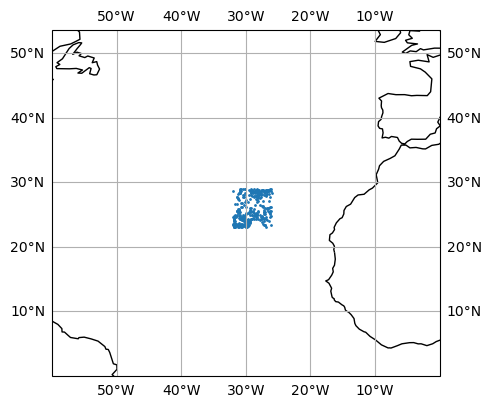

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([0,-60, 0,50])
ax.gridlines(draw_labels=True)

ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',label='Section 1: Western North Atlantic',s=1)

**Notebook Updates Here**

I'm adding a bit to this notebook focusing on the sample rates of different floats. Below are sections of the sample rate collected for each profile. Below this is how the CT section would look if only using the locations where the sample rate is lower than every 2.5m. I also added the following updates to the notebook:
- The average profiles for CT and SA pathways include thick lines (which include data from all profiles) and thin lines (which only include data for the `sample_max` set below)
- Added a mask for the CT and SA sections below, to compare with the variance sections. This makes it pretty clear how big of an impact the sample rate has on amount of variance/amount of variance in the mesoscale pathway.
- Added 2D histograms with total variance vs mesoscale variance and total variance vs mesoscale variance ratio, for both CT and SA.
- Added T-S diagrams were the heatmap coloring is by:
  - number of points in each bin
  - volume of water in each bin
  - total variance in each bin

In [6]:
x='N_PROF_NEW'
y='PRES_INTERPOLATED'
sample_max = 2.5

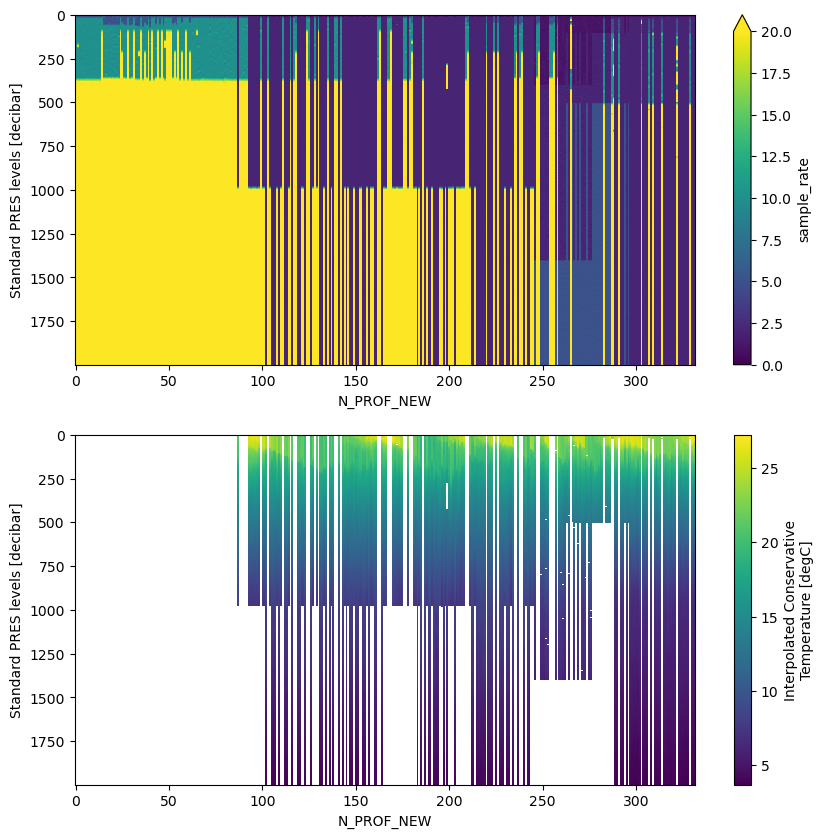

In [7]:
plt.figure(figsize=(10,10))

plt.subplot(211)
ds.sample_rate.plot(x=x,y=y,vmin=0,vmax=20)
plt.gca().invert_yaxis()

plt.subplot(212)
ds.CT.where(ds.sample_rate<sample_max).plot(x=x,y=y)
plt.gca().invert_yaxis()

# Calculate Terms

In [8]:
lfilt = 100

ct_b = ds.CT
sa_b = ds.SA

ct_m = ff.ds_filt_single(ds, lfilt, 'CT')
sa_m = ff.ds_filt_single(ds, lfilt, 'SA')

ct_e = ct_b - ct_m
sa_e = sa_b - sa_m

In [9]:
K_rho4 = 10**(-4)
K_rho5 = 10**(-5)
K_rho6 = 10**(-6)

In [10]:
ct_2 = K_rho5*ff.da_filt_single((ct_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)
sa_2 = K_rho5*ff.da_filt_single((sa_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)

ct_3 = K_rho5*(ct_m.differentiate(coord='PRES_INTERPOLATED'))**2
sa_3 = K_rho5*(sa_m.differentiate(coord='PRES_INTERPOLATED'))**2

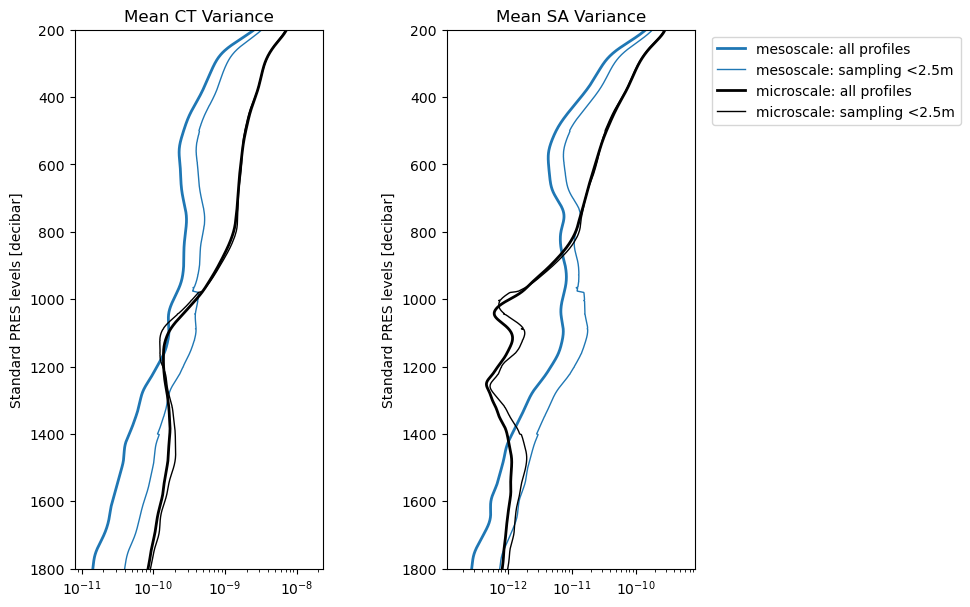

In [11]:
plt.figure(figsize=(8,7))

plt.subplot(121)
ct_2.mean('N_PROF').plot(y='PRES_INTERPOLATED',linewidth=2,label='mesoscale: all profiles')
ct_2.where(ds.sample_rate<sample_max).mean('N_PROF').plot(y='PRES_INTERPOLATED',color='tab:blue',linewidth=1,label='mesoscale: sampling <2.5m')
ct_3.mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth=2, label='microscale: all profiles')
ct_3.where(ds.sample_rate<sample_max).mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth=1, label='microscale: sampling <2.5m')
plt.xscale('log')
plt.legend(bbox_to_anchor=(3.6,1))
plt.ylim(1800,200)
plt.title('Mean CT Variance')

plt.subplot(122)
sa_2.mean('N_PROF').plot(y='PRES_INTERPOLATED',linewidth=2)
sa_2.where(ds.sample_rate<sample_max).mean('N_PROF').plot(y='PRES_INTERPOLATED',color='tab:blue',linewidth=1)
sa_3.mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth=2)
sa_3.where(ds.sample_rate<sample_max).mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth=1)
plt.xscale('log')
plt.ylim(1800,200)
plt.title('Mean SA Variance')

plt.subplots_adjust(wspace=0.5)

# Variance Sections

In [18]:
ct_start = 10**-12
ct_end   = 10**-8
ct_norm  = colors.LogNorm(vmin=ct_start, vmax=ct_end)
ct_cmap  = cmo.matter_r

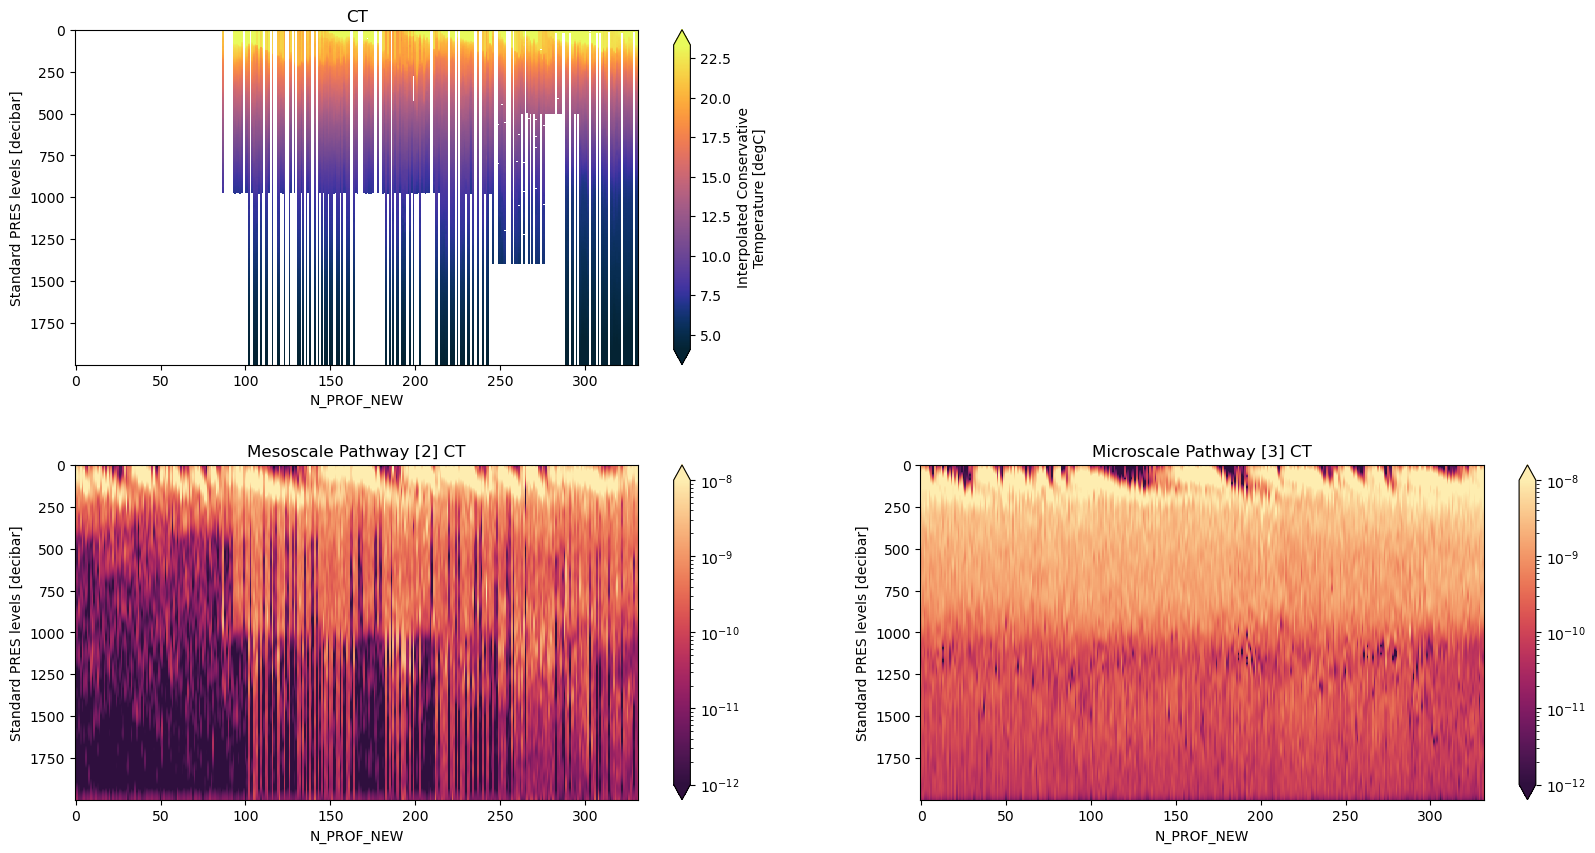

In [19]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ds.CT.where(ds.sample_rate<sample_max).sortby(x).plot(x=x, y=y, cmap=cmo.thermal, robust=True)
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(223)
#ct_2.sortby(x).where(ct_2.mask==1).plot(x=x, y=y, norm=ct_norm, cmap=ct_cmap)
ct_2.sortby(x).plot(x=x, y=y, norm=ct_norm, cmap=ct_cmap)
plt.gca().invert_yaxis()
plt.title('Mesoscale Pathway [2] CT')

plt.subplot(224)
#ct_3.sortby(x).where(ct_3.mask==1).plot(x=x, y=y, norm=ct_norm, cmap=ct_cmap)
ct_3.sortby(x).plot(x=x, y=y, norm=ct_norm, cmap=ct_cmap)
plt.gca().invert_yaxis()
plt.title('Microscale Pathway [3] CT')

plt.subplots_adjust(hspace=0.3)

In [20]:
sa_start = 10**-14
sa_end   = 10**-10
sa_norm  = colors.LogNorm(vmin=sa_start, vmax=sa_end)
sa_cmap  = cmo.matter_r

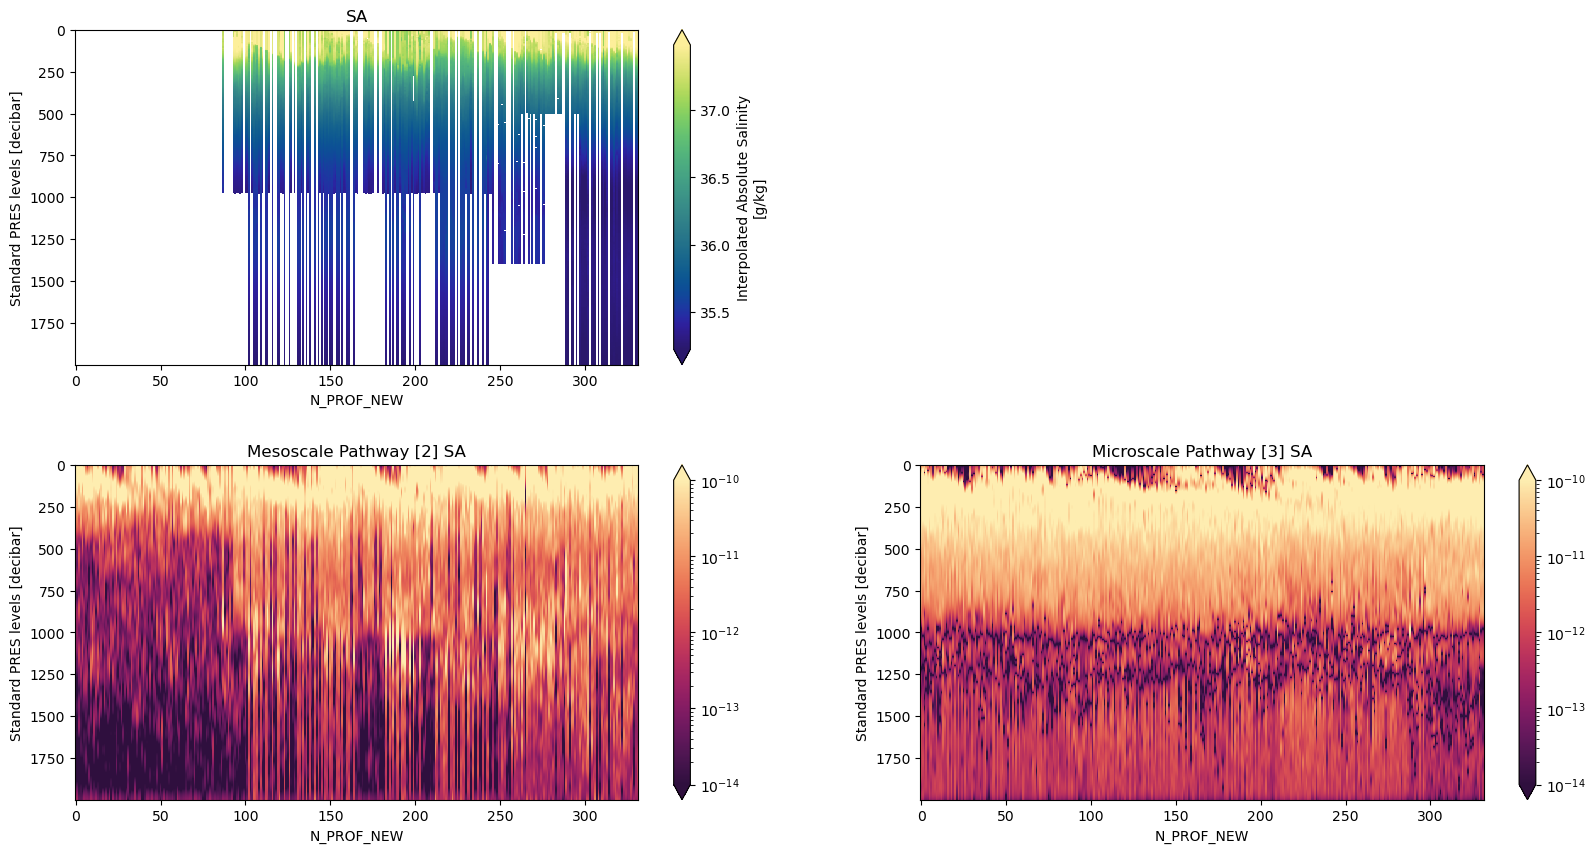

In [21]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ds.SA.where(ds.sample_rate<sample_max).sortby(x).plot(x=x, y=y, cmap=cmo.haline, robust=True)
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(223)
#sa_2.sortby(x).where(sa_2.mask==1).plot(x=x, y=y, norm=sa_norm, cmap=sa_cmap)
sa_2.sortby(x).plot(x=x, y=y, norm=sa_norm, cmap=sa_cmap)
plt.gca().invert_yaxis()
plt.title('Mesoscale Pathway [2] SA')

plt.subplot(224)
#sa_3.sortby(x).where(sa_3.mask==1).plot(x=x, y=y, norm=sa_norm, cmap=sa_cmap)
sa_3.sortby(x).plot(x=x, y=y, norm=sa_norm, cmap=sa_cmap)
plt.gca().invert_yaxis()
plt.title('Microscale Pathway [3] SA')

plt.subplots_adjust(hspace=0.3)

# Ratio Sections

In [22]:
ct_tot  = ct_2 + ct_3
ct_2rat = ct_2/ct_tot
ct_3rat = ct_3/ct_tot

sa_tot  = sa_2 + sa_3
sa_2rat = sa_2/sa_tot
sa_3rat = sa_3/sa_tot

In [23]:
ctrat_start = 10**-11
ctrat_end   = 10**-8
ctrat_norm  = colors.LogNorm(vmin=ctrat_start, vmax=ctrat_end)
rat_cmap  = cmo.matter_r

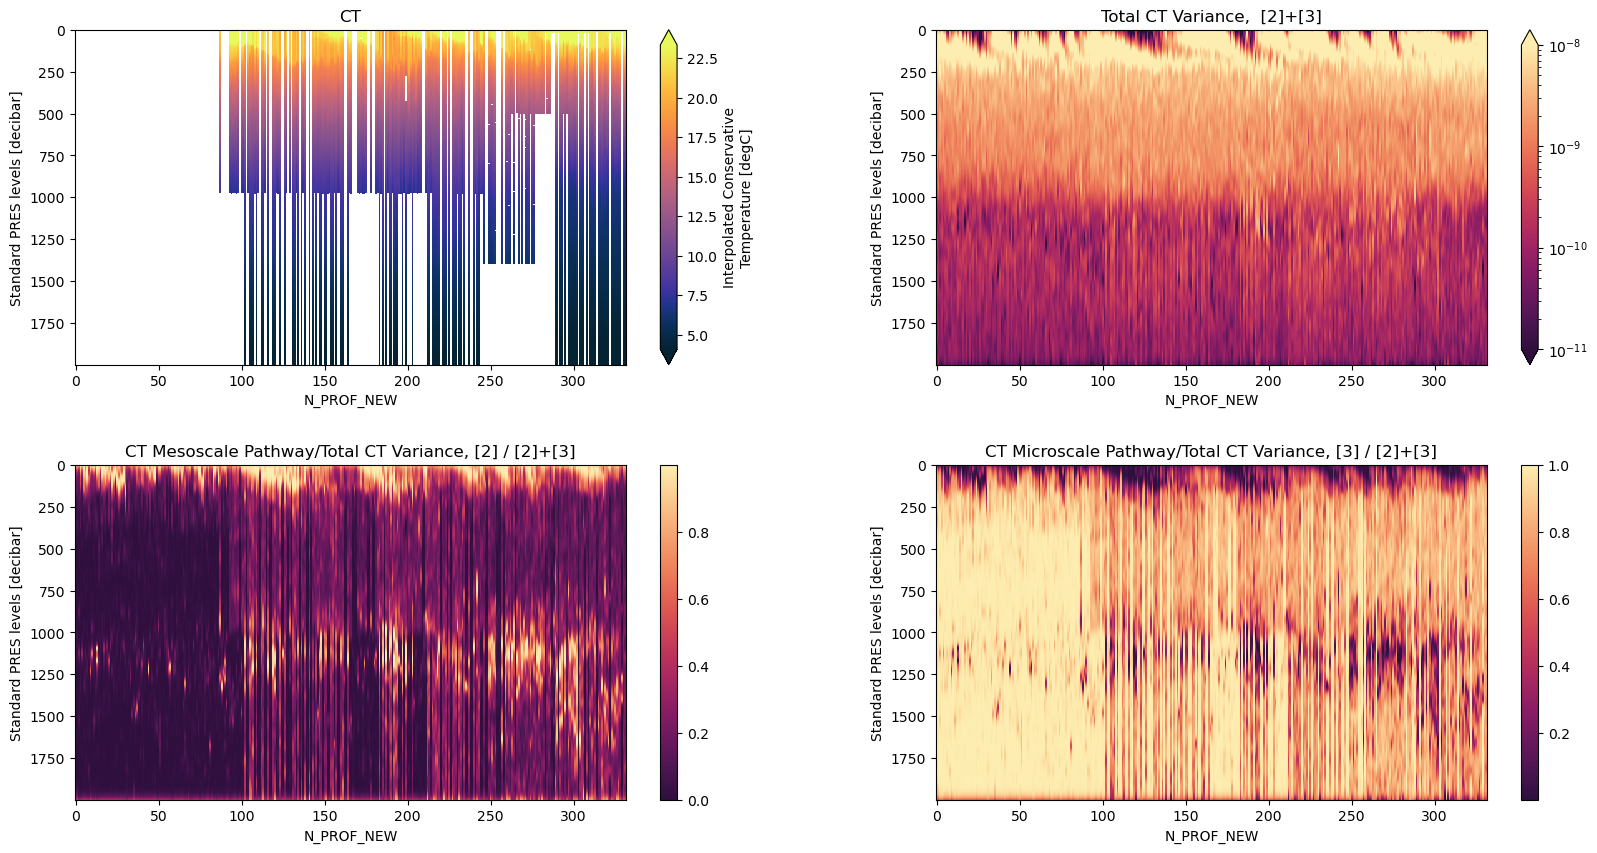

In [24]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ds.CT.where(ds.sample_rate<sample_max).sortby(x).plot(x=x, y=y, cmap=cmo.thermal, robust=True)
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(222)
#ct_tot.sortby(x).where(ct_tot.mask==1).plot(x=x, y=y, norm=ctrat_norm, cmap=rat_cmap)
ct_tot.sortby(x).plot(x=x, y=y, norm=ctrat_norm, cmap=rat_cmap)
plt.gca().invert_yaxis()
plt.title('Total CT Variance,  [2]+[3]')

plt.subplot(223)
#ct_2rat.sortby(x).where(ct_2rat.mask==1).plot(x=x, y=y, cmap=rat_cmap)
ct_2rat.sortby(x).plot(x=x, y=y, cmap=rat_cmap)
plt.gca().invert_yaxis()
plt.title('CT Mesoscale Pathway/Total CT Variance, [2] / [2]+[3]')

plt.subplot(224)
#ct_3rat.sortby(x).where(ct_3rat.mask==1).plot(x=x, y=y, cmap=rat_cmap)
ct_3rat.sortby(x).plot(x=x, y=y, cmap=rat_cmap)
plt.gca().invert_yaxis()
plt.title('CT Microscale Pathway/Total CT Variance, [3] / [2]+[3]')

plt.subplots_adjust(hspace=0.3, wspace=0.25)

In [25]:
sarat_start = 10**-13
sarat_end   = 10**-9
sarat_norm  = colors.LogNorm(vmin=sarat_start, vmax=sarat_end)
rat_cmap  = cmo.matter_r

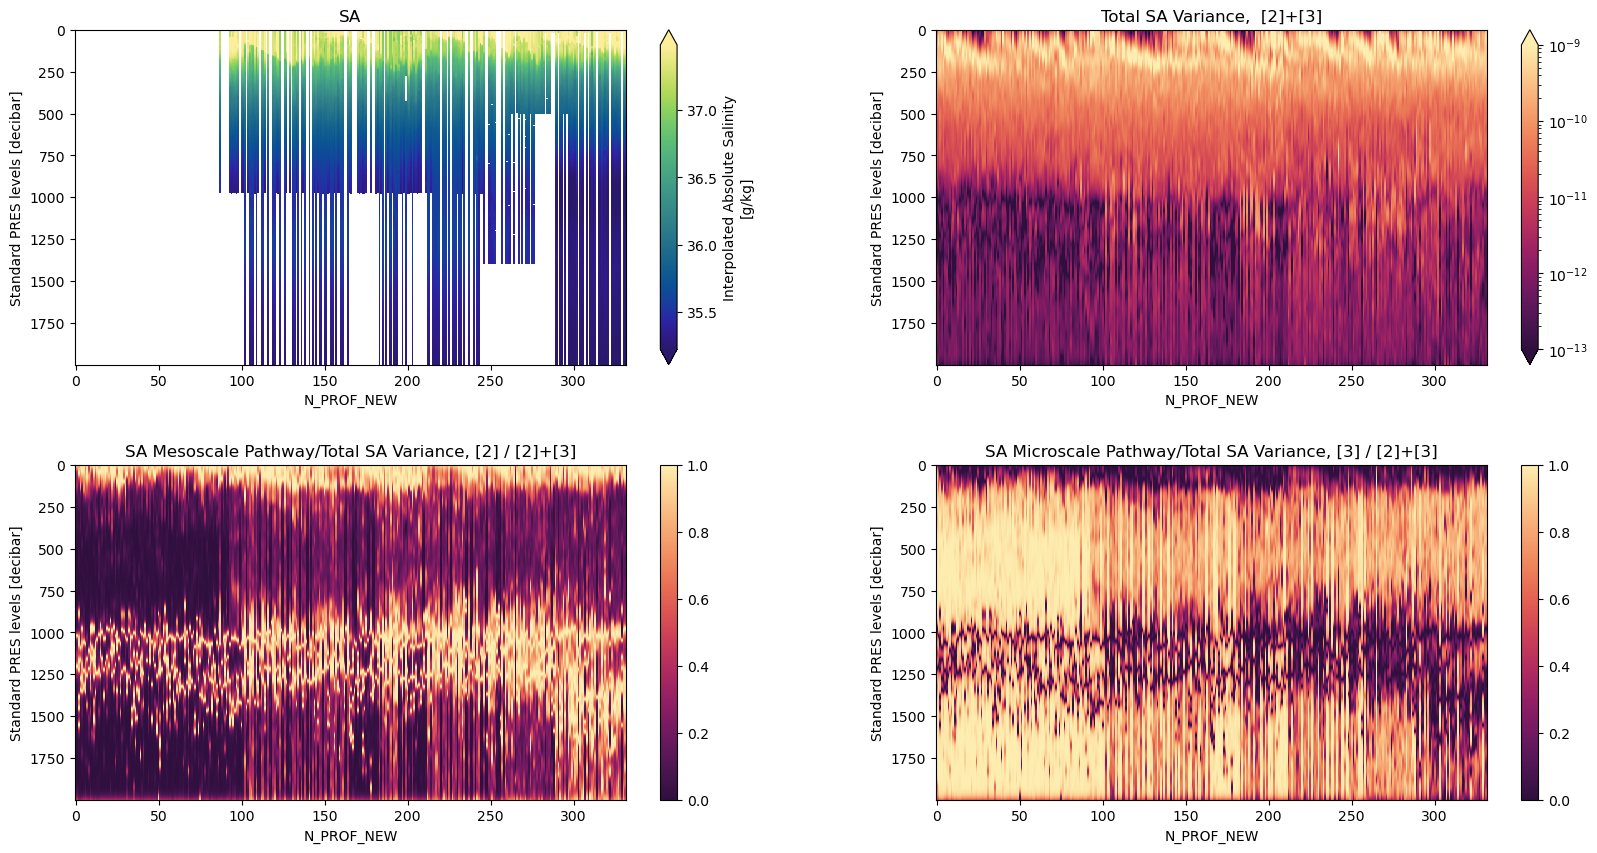

In [26]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ds.SA.where(ds.sample_rate<sample_max).sortby(x).plot(x=x, y=y, cmap=cmo.haline, robust=True)
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(222)
#sa_tot.sortby(x).where(sa_tot.mask==1).plot(x=x, y=y, norm=sarat_norm, cmap=rat_cmap)
sa_tot.sortby(x).plot(x=x, y=y, norm=sarat_norm, cmap=rat_cmap)
plt.gca().invert_yaxis()
plt.title('Total SA Variance,  [2]+[3]')

plt.subplot(223)
#sa_2rat.sortby(x).where(sa_2rat.mask==1).plot(x=x, y=y, cmap=cmo.matter_r)
sa_2rat.sortby(x).plot(x=x, y=y, cmap=cmo.matter_r)
plt.gca().invert_yaxis()
plt.title('SA Mesoscale Pathway/Total SA Variance, [2] / [2]+[3]')

plt.subplot(224)
#sa_3rat.sortby(x).where(sa_3rat.mask==1).plot(x=x, y=y, cmap=cmo.matter_r)
sa_3rat.sortby(x).plot(x=x, y=y, cmap=cmo.matter_r)
plt.gca().invert_yaxis()
plt.title('SA Microscale Pathway/Total SA Variance, [3] / [2]+[3]')

plt.subplots_adjust(hspace=0.3, wspace=0.25)

# 2D Histograms

In [27]:
bins=50

x1 = ct_tot.where(ds.sample_rate<2.5).mean('N_PROF')
y1 = ct_2.where(ds.sample_rate<2.5).mean('N_PROF')
x1_bins = np.logspace(np.log10(min(x1)), np.log10(max(x1)), bins)
y1_bins = np.logspace(np.log10(min(y1)), np.log10(max(y1)), bins)

x2 = ct_tot.where(ds.sample_rate<2.5).mean('N_PROF')
y2 = ct_2rat.where(ds.sample_rate<2.5).mean('N_PROF')
x2_bins = np.logspace(np.log10(min(x2)), np.log10(max(x2)), bins)
y2_bins = np.linspace(min(y2), max(y2), bins)

x3 = sa_tot.where(ds.sample_rate<2.5).mean('N_PROF')
y3 = sa_2.where(ds.sample_rate<2.5).mean('N_PROF')
x3_bins = np.logspace(np.log10(min(x3)), np.log10(max(x3)), bins)
y3_bins = np.logspace(np.log10(min(y3)), np.log10(max(y3)), bins)

x4 = sa_tot.where(ds.sample_rate<2.5).mean('N_PROF')
y4 = sa_2rat.where(ds.sample_rate<2.5).mean('N_PROF')
x4_bins = np.logspace(np.log10(min(x4)), np.log10(max(x4)), bins)
y4_bins = np.linspace(min(y4), max(y4), bins)

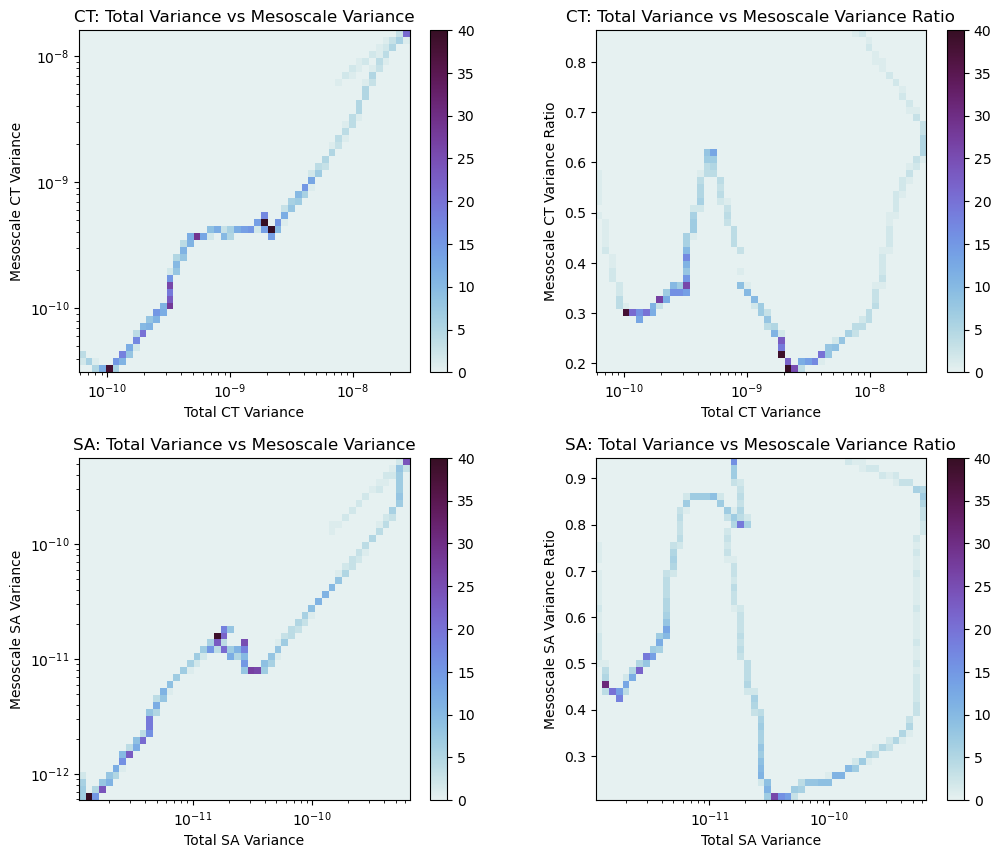

In [107]:
plt.figure(figsize=(12,10))
vmin=0
vmax=40

plt.subplot(221)
plt.hist2d(x1, y1, bins=[x1_bins, y1_bins], cmap=cmo.dense, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total CT Variance')
plt.ylabel('Mesoscale CT Variance')
plt.title('CT: Total Variance vs Mesoscale Variance')


plt.subplot(222)
plt.hist2d(x2, y2, bins=[x2_bins, y2_bins], cmap=cmo.dense, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Total CT Variance')
plt.ylabel('Mesoscale CT Variance Ratio')
plt.title('CT: Total Variance vs Mesoscale Variance Ratio')


plt.subplot(223)
plt.hist2d(x3, y3, bins=[x3_bins, y3_bins], cmap=cmo.dense, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total SA Variance')
plt.ylabel('Mesoscale SA Variance')
plt.title('SA: Total Variance vs Mesoscale Variance')


plt.subplot(224)
plt.hist2d(x4, y4, bins=[x4_bins, y4_bins], cmap=cmo.dense, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Total SA Variance')
plt.ylabel('Mesoscale SA Variance Ratio')
plt.title('SA: Total Variance vs Mesoscale Variance Ratio')

plt.subplots_adjust(wspace=0.25,hspace=0.25)

# T-S Diagrams

In [78]:
sbins = np.arange(ds.SA.min(),ds.SA.max(), 0.025)
tbins = np.arange(ds.CT.min(),ds.CT.max(), 0.1)

s = ds.SA.where(ds.sample_rate<2.5)
t = ds.CT.where(ds.sample_rate<2.5)

/home.ufs/amf2288/mambaforge-pypy3/envs/Argo_Nov_24/lib/python3.12/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'T-S Diagram, by # of points')

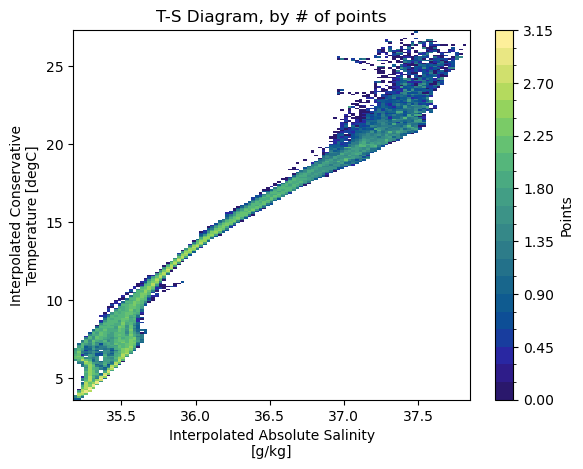

In [124]:
# histogram of number of data points
hTS = histogram(s, t, bins=[sbins, tbins])
np.log10(hTS.T).plot(levels=31,cbar_kwargs={'label': 'Points'},cmap=cmo.haline)
plt.title('T-S Diagram, by # of points')

Text(0.5, 1.0, 'T-S Diagram, by volume of water')

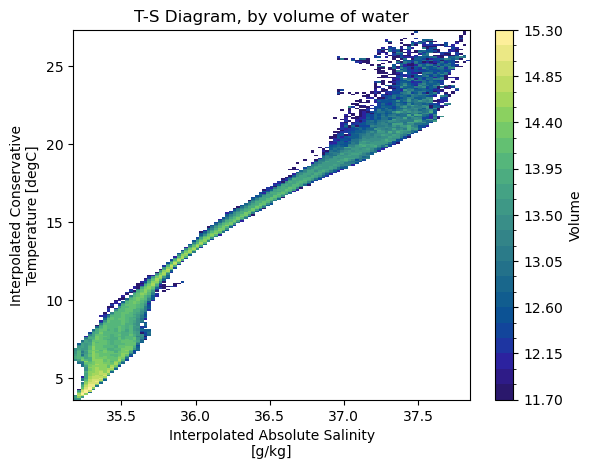

In [125]:
# histogram of number of data points weighted by volume resolution
# Note that depth is a non-uniform axis

# Create a dz variable
dz = np.diff(ds.PRES_INTERPOLATED)
dz =np.insert(dz, 0, dz[0])
dz = xr.DataArray(dz, coords= {'lev':ds.PRES_INTERPOLATED}, dims='PRES_INTERPOLATED')

# weight by volume of grid cell (resolution = 5degree, 1degree=110km)
dVol = dz * (5*110e3) * (5*110e3*np.cos(ds.LATITUDE*np.pi/180))

# Note: The weights are automatically broadcast to the right size
hTSw = histogram(ds.SA, ds.CT, bins=[sbins, tbins], weights=dVol)
np.log10(hTSw.T).plot(levels=31, cmap=cmo.haline,cbar_kwargs={'label': 'Volume'})
plt.title('T-S Diagram, by volume of water')

In [120]:
ctvar_start = 10**-10
ctvar_end   = 10**-7
ctvar_norm  = colors.LogNorm(vmin=ctvar_start, vmax=ctvar_end)
ctvar_cmap  = cmo.matter_r

savar_start = 10**-11
savar_end   = 10**-9
savar_norm  = colors.LogNorm(vmin=savar_start, vmax=savar_end)
savar_cmap  = cmo.matter_r

Text(0.5, 1.0, 'T-S Diagram, by SA variance')

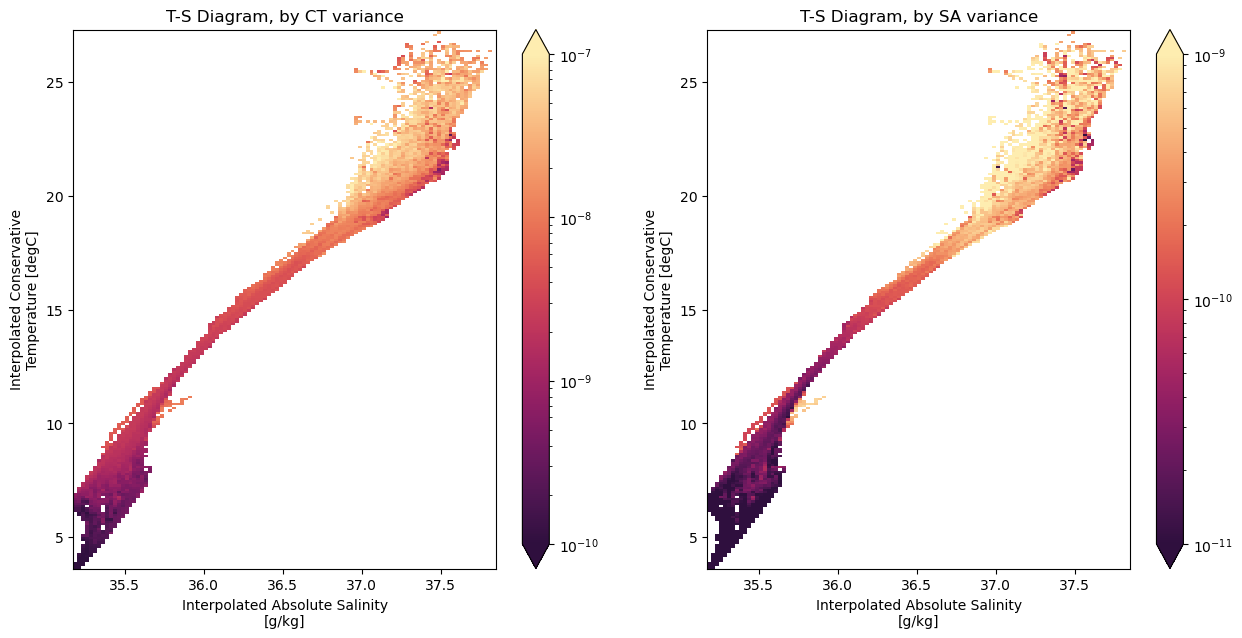

In [130]:
plt.figure(figsize=(15,7))

plt.subplot(121)
ctvar = ct_tot
hTSO2 = (histogram(s.where(~np.isnan(ctvar)),
                   t.where(~np.isnan(ctvar)),
                   bins=[sbins, tbins],
                   weights=ctvar.where(~np.isnan(ctvar))*dVol)/
                histogram(s.where(~np.isnan(ctvar)),
                          t.where(~np.isnan(ctvar)),
                          bins=[sbins, tbins],
                          weights=dVol))
(hTSO2.T).plot(norm=ctvar_norm, cmap=ctvar_cmap,cbar_kwargs={'label': ''})
plt.title('T-S Diagram, by CT variance')

plt.subplot(122)
savar = sa_tot
hTSO2 = (histogram(s.where(~np.isnan(savar)),
                   t.where(~np.isnan(savar)),
                   bins=[sbins, tbins],
                   weights=savar.where(~np.isnan(var))*dVol)/
                histogram(s.where(~np.isnan(savar)),
                          t.where(~np.isnan(savar)),
                          bins=[sbins, tbins],
                          weights=dVol))
(hTSO2.T).plot(norm=savar_norm, cmap=savar_cmap,cbar_kwargs={'label': ''})
plt.title('T-S Diagram, by SA variance')